In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from scipy import stats
from scipy.stats import chisquare, chi2_contingency
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
palette = sns.diverging_palette(220, 20)
import pickle
%matplotlib inline
import random
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
df = pd.read_pickle('../data/interim/train_clean.pickle')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_encoded,AppVersion_encoded,EngineVersion_encoded,OsVer_encoded,Census_OSBranch_release_encoded
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,0,0,10.0,0,273,18,15100,10.0,rs4_release
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,0,0,8.0,0,Other,13,14600,10.0,rs4_release
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,0,0,3.0,0,273,18,15100,10.0,rs4_release
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,0,0,3.0,1,273,18,15100,10.0,rs4_release
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,0,0,1.0,1,273,18,15100,10.0,rs4_release


In [3]:
df.shape

(8921478, 71)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921478 entries, 0 to 8921482
Data columns (total 71 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [5]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in binary_col]

## Numerical data

Note: data is discrete (except Census_InternalPrimaryDiagonalDisplaySizeInInches). These features can be considered categorical as well.

In [6]:
df[num_col].head(10)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical
0,4.0,476940.0,299451.0,4096.0,18.900000,1440.0,900.0
1,4.0,476940.0,102385.0,4096.0,13.900000,1366.0,768.0
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0
5,2.0,114473.0,113671.0,8192.0,21.500000,1920.0,1080.0
6,2.0,476940.0,458702.0,4096.0,17.200001,1600.0,900.0
7,2.0,305245.0,290807.0,4096.0,15.500000,1366.0,768.0
8,4.0,305245.0,303892.0,4096.0,15.600000,1920.0,1080.0
9,4.0,953869.0,203252.0,8192.0,15.500000,1366.0,768.0


In [7]:
[df[col].nunique() for col in num_col]

[45, 5733, 536848, 3446, 784, 2179, 1559]

In [8]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8880172.0,3.989694,2.082554,1.0,2.0,4.0,4.000000,1.920000e+02
Census_PrimaryDiskTotalCapacity,8868462.0,513096.687500,363716.062500,0.0,239372.0,476940.0,953869.000000,9.537024e+07
Census_SystemVolumeTotalCapacity,8868476.0,377367.843750,325879.031250,0.0,120775.0,249500.0,475973.000000,4.768710e+07
Census_TotalPhysicalRAM,8840945.0,6115.259766,5115.821777,255.0,4096.0,4096.0,8192.000000,1.572864e+06
Census_InternalPrimaryDiagonalDisplaySizeInInches,8874344.0,16.676197,5.892929,3.0,13.9,15.5,17.200001,1.823000e+02
Census_InternalPrimaryDisplayResolutionHorizontal,8874336.0,1547.743408,368.317566,144.0,1366.0,1366.0,1920.000000,1.228800e+04
Census_InternalPrimaryDisplayResolutionVertical,8874336.0,897.587463,214.592697,171.0,768.0,768.0,1080.000000,8.640000e+03


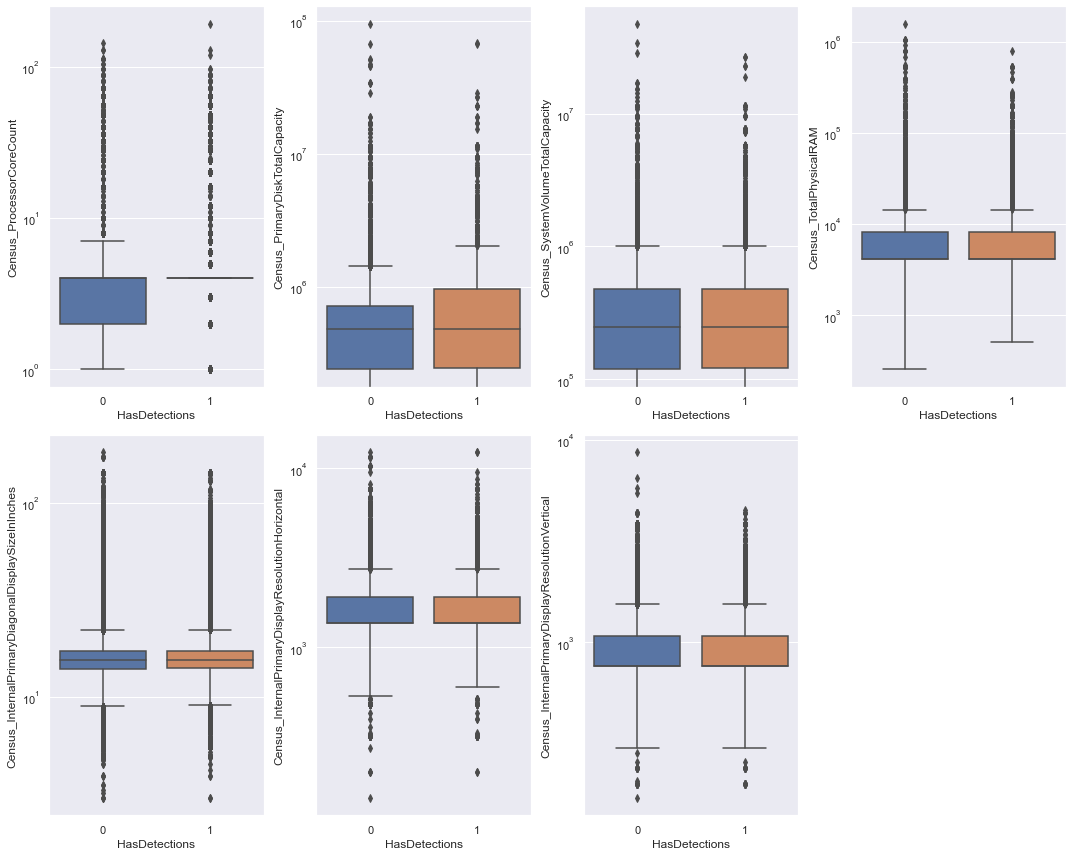

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(15, 12))

for col, ax in zip(num_col, axes.flatten()):
    sns.boxplot(data=df,
                y=col, 
                x='HasDetections',
                orient='v', 
                ax=ax)
    ax.set_yscale('log')

axes.flat[-1].set_visible(False)
plt.subplots_adjust(wspace=2.5)
plt.tight_layout()

In [10]:
num_col_name_dict = {'Census_ProcessorCoreCount':'Number of Cores',
                     'Census_PrimaryDiskTotalCapacity':'Disk Capacity (MB)',
                     'Census_SystemVolumeTotalCapacity':'System Capacity (MB)',
                     'Census_TotalPhysicalRAM': 'RAM (MB)',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches':'Display Size (in)',
                     'Census_InternalPrimaryDisplayResolutionHorizontal':'Horizontal Resolution (px)',
                     'Census_InternalPrimaryDisplayResolutionVertical':'Vertical Resolution (px)',
                     }
bin_col_name_dict = {'IsSxsPassiveMode':'Passive Mode',
                     'HasTpm':'Tpm',
                     'AutoSampleOptIn':'Auto Sample',
                     'SMode':'SMode',
                     'Firewall':'Firewall',
                     'Census_HasOpticalDiskDrive':'Optical Disk Drive',
                     'Census_IsPortableOperatingSystem':'Portable OS',
                     'Census_IsFlightsDisabled':'Flights Disabled',
                     'Census_IsSecureBootEnabled':'Secure Boot',
                     'Census_IsVirtualDevice':'Virtual Device',
                     'Census_IsTouchEnabled':'Touch Enabled',
                     'Census_IsPenCapable':'Pen Capable',
                     'Census_IsAlwaysOnAlwaysConnectedCapable':'Always Connected Capable',
                     'Wdft_IsGamer':'Gamer',
                     'HasDetections':'HasDetections'
                     }

<Figure size 1080x1080 with 0 Axes>

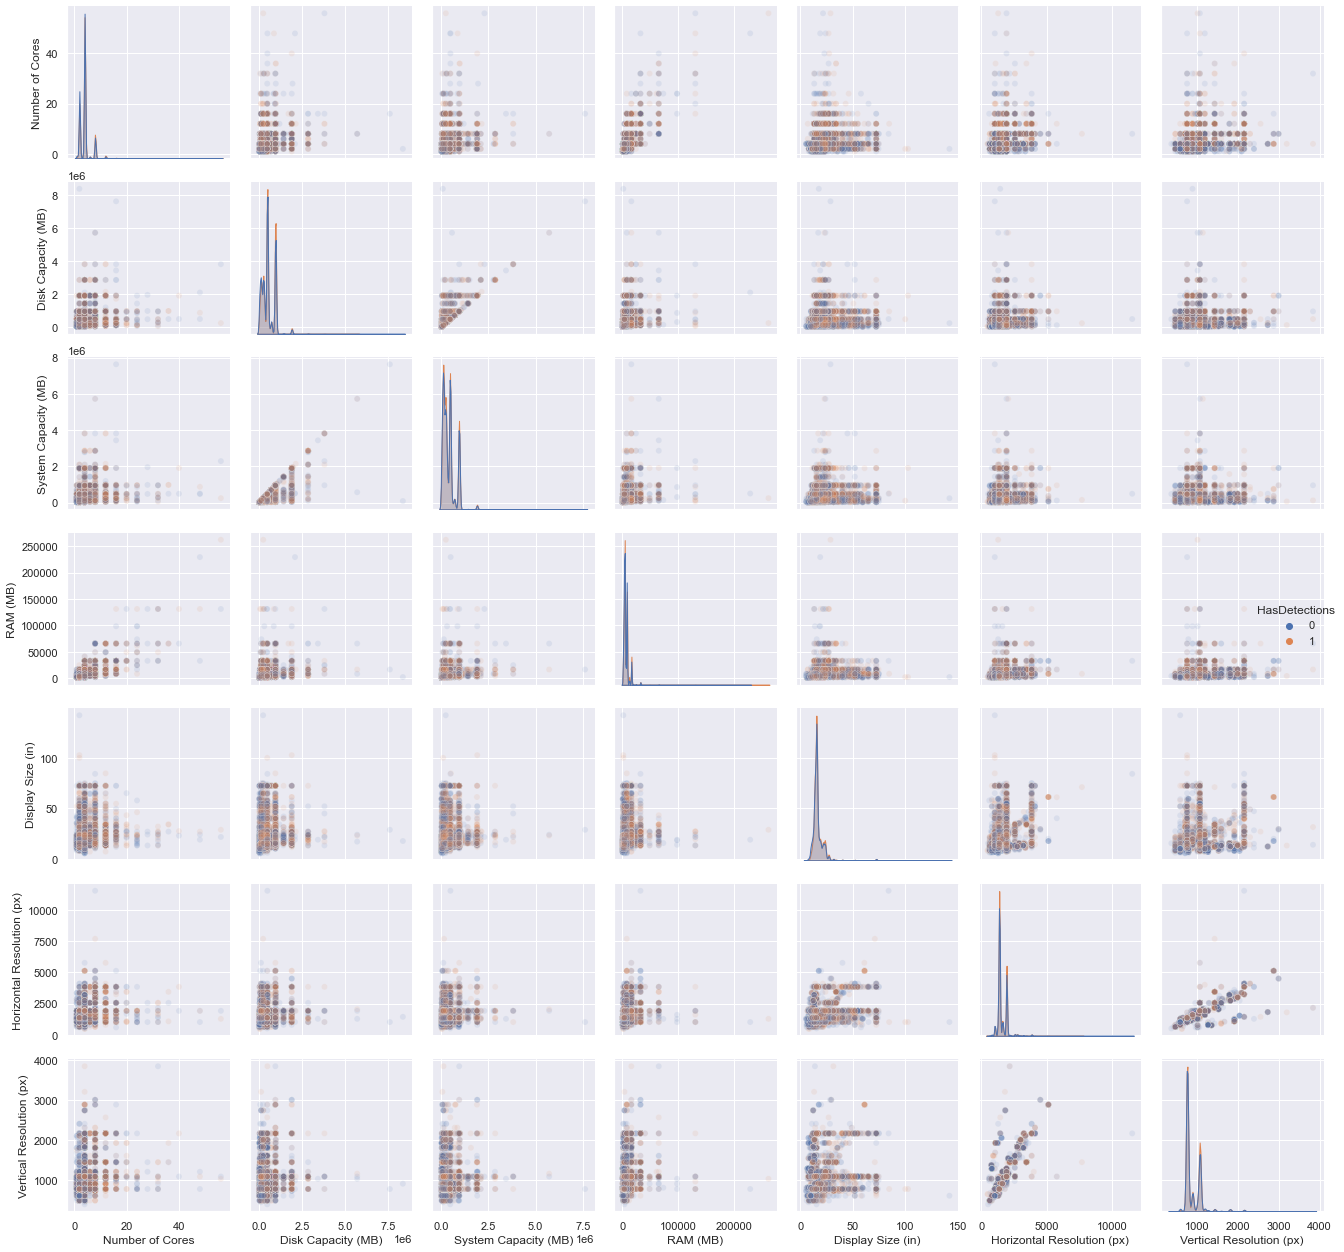

In [11]:
df_sample = df[num_col+['HasDetections']].rename(columns=num_col_name_dict).sample(frac=0.01, random_state=42)

plt.figure(figsize=(15,15))
sns.pairplot(df_sample, 
             hue='HasDetections', 
             #kind='reg',
             diag_kind='kde',
             plot_kws={'alpha': 0.1})
             #plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.subplots_adjust(hspace=.2, wspace=.2)
plt.tight_layout();

Horizontal and vertical resolution are highly correlated. Also system and disk capacity, and RAM and number of cores, are correlated. The other features do not show a particular relationship with each other. Even if the obvious outliers were removed in the data wrangling notebook, there still is a number of rare values. I will initially choose ML algorithms which are not sensitive to outliers, I might iterate a second time to evaluate the performace without outliers. However, since these numerical features do not seem very predictive, outliers should not play a big role. 

Let's check the correlation between features. Note that we are violating Pearson correlation assumptions:
  - Most features are ordinal, however the level of measurement is high enough to consider these variables as continuos;
  - Variables are not normally distributed and error variance is not constant across the features (Heteroscedasticity);
  - As seen, we still have outliers.
 
Spearman's correlation, which only requires ordinal data and the scores of variables monotonically related to the other variable, is more appropriate in this case. I will proceed with both correlations, but Spearman should be considered as the more reliable here.

<AxesSubplot:>

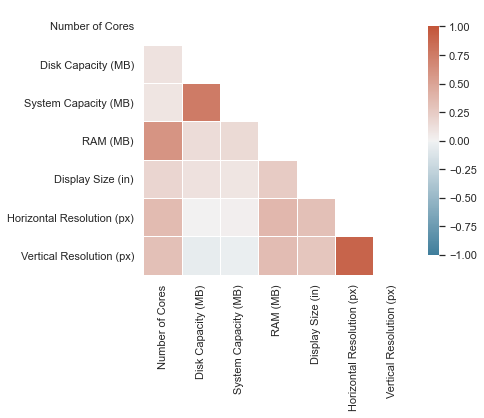

In [12]:
sns.set_style('whitegrid')
corr_matrix = df[num_col].rename(columns=num_col_name_dict).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

<AxesSubplot:>

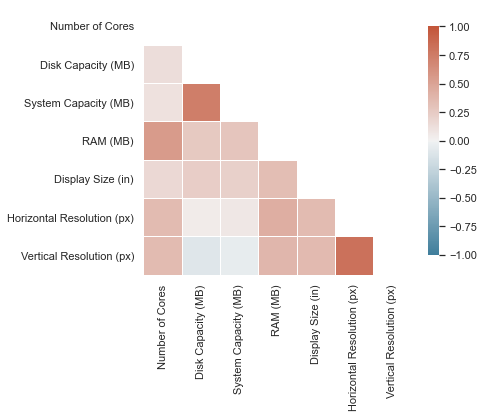

In [13]:
corr_matrix = df[num_col].rename(columns=num_col_name_dict).corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

As expected the vertical and horizontal resolutions are highly correlated. So are the disk capacity and system capacity, since one is a fraction of the other, and the RAM and number of processor cores.

Let's look at the distributions of target variable with a logistic regression plot:

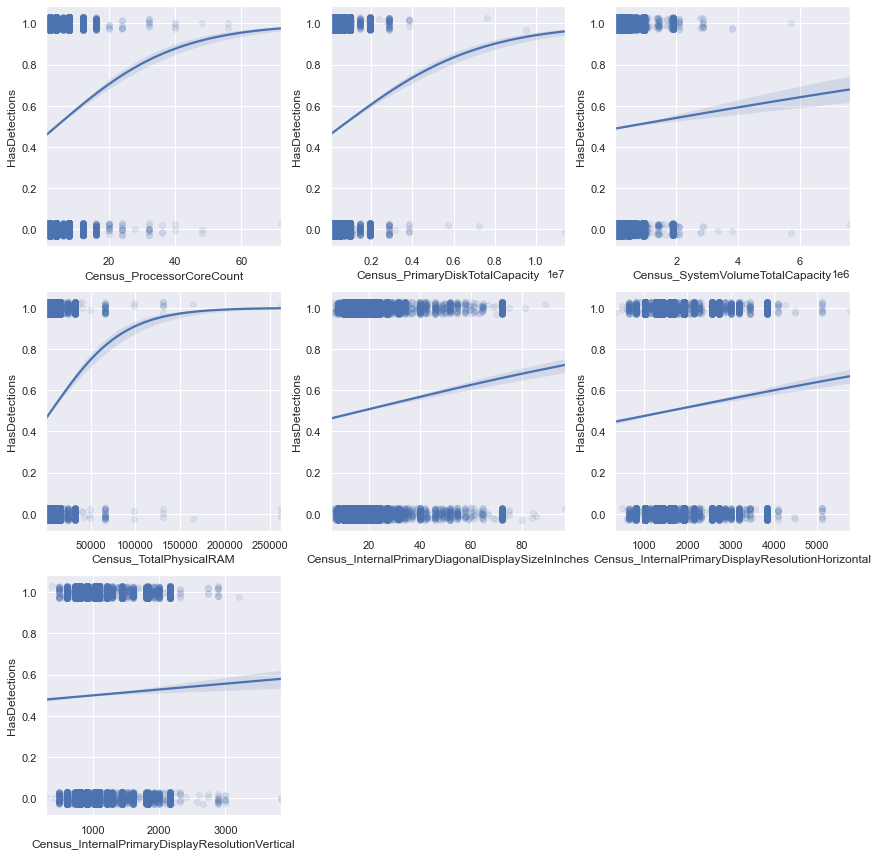

In [14]:
random.seed = 42

df['HasDetections'] = df['HasDetections'].astype('float')

sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, ax in zip(num_col, axes.flatten()):
    sns.regplot(data=df[num_col+['HasDetections']].sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.tight_layout()

Let's look at it without outliers (remove data with z-score>3):

In [15]:
z_score = np.abs(stats.zscore(df[num_col], nan_policy='omit'))
sum(z_score>3)/df[num_col].shape[0]*100

array([1.33069879, 1.23333824, 0.82981766, 0.9000975 , 1.22248802,
       1.72831228, 1.95568492])

In [16]:
outlier_indices = df[num_col][z_score > 3].index
no_df = df.iloc[~df.index.isin(outlier_indices), :]
no_df.shape

(8395370, 71)

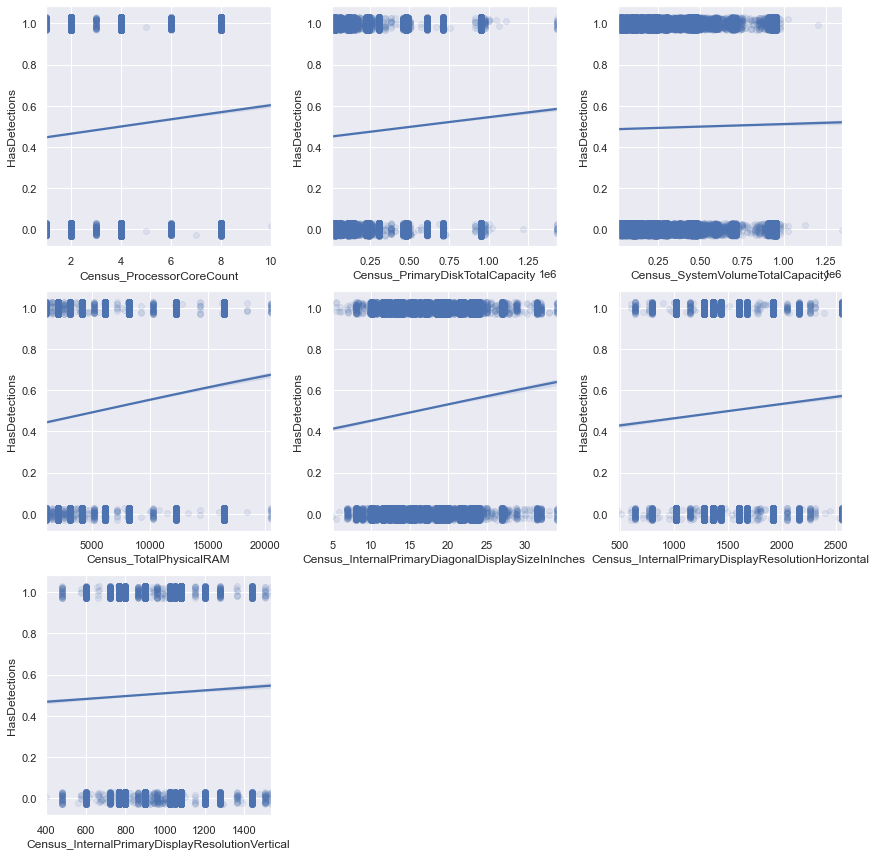

In [17]:
random.seed = 42

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, ax in zip(num_col, axes.flatten()):
    sns.regplot(data=no_df[num_col+['HasDetections']].sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.tight_layout()

### Mutual Information between numerical features and target variable

In [18]:
df_dropna = df.copy().dropna()

In [19]:
X = df_dropna[num_col]
y = df_dropna['HasDetections']

In [20]:
mi = mutual_info_classif(X, y, random_state=42)
mi_num = pd.DataFrame({'MI':mi}, index=num_col)    
mi_num.sort_values('MI', ascending=False).dropna()

,MI
Census_ProcessorCoreCount,0.177780
Census_InternalPrimaryDisplayResolutionVertical,0.149581
Census_InternalPrimaryDisplayResolutionHorizontal,0.137542
Census_TotalPhysicalRAM,0.113533
Census_PrimaryDiskTotalCapacity,0.077795
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.046705
Census_SystemVolumeTotalCapacity,0.012923


### Binary features

In [21]:
binary_col

['IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [22]:
binary_df = df[binary_col].copy().astype('float')
binary_df.head()

,IsSxsPassiveMode,HasTpm,AutoSampleOptIn,SMode,Firewall,Census_HasOpticalDiskDrive,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,HasDetections
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


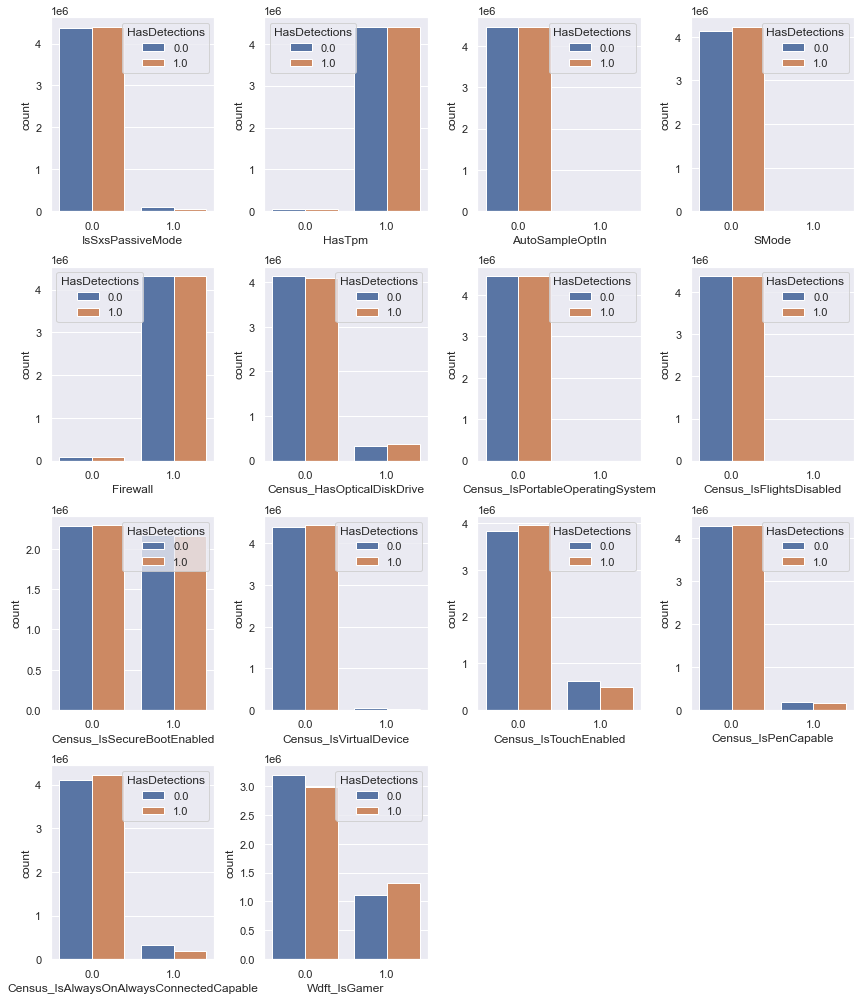

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12, 14))

for col, ax in zip(binary_col, axes.flatten()):
    sns.countplot(data=binary_df,
                  x=col, 
                  hue='HasDetections', 
                  ax=ax)

axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)

plt.subplots_adjust(wspace=1.5)
plt.tight_layout()

IsSxsPassiveMode, SMode, Census_IsTouchEnabled, Census_IsAlwaysOnAlwaysConnectedCapable, Wdft_IsGamer show less detections for the positive class. Census_HasOpticalDiskDrive has more detections for the positive class. The other features' classes are equally distributed among detection and no detection.  

<AxesSubplot:>

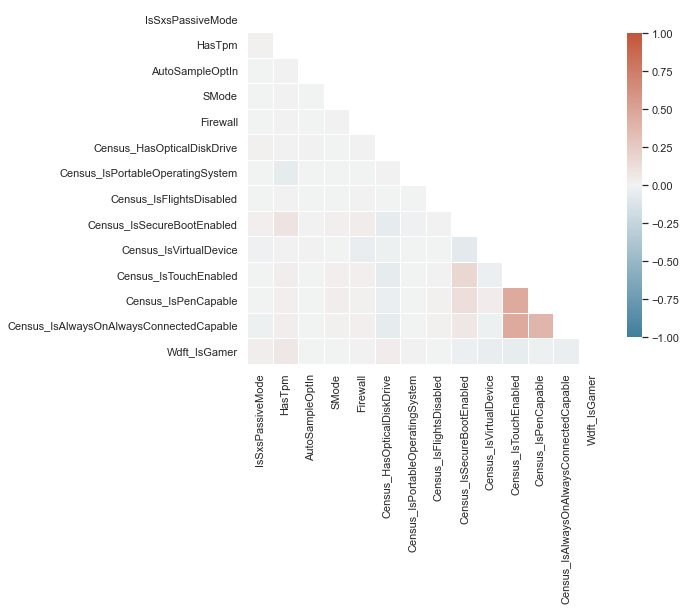

In [24]:
point_biserial_corr_matrix = binary_df.drop('HasDetections', axis=1).corr()
mask = np.triu(np.ones_like(point_biserial_corr_matrix, dtype=bool))
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(point_biserial_corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


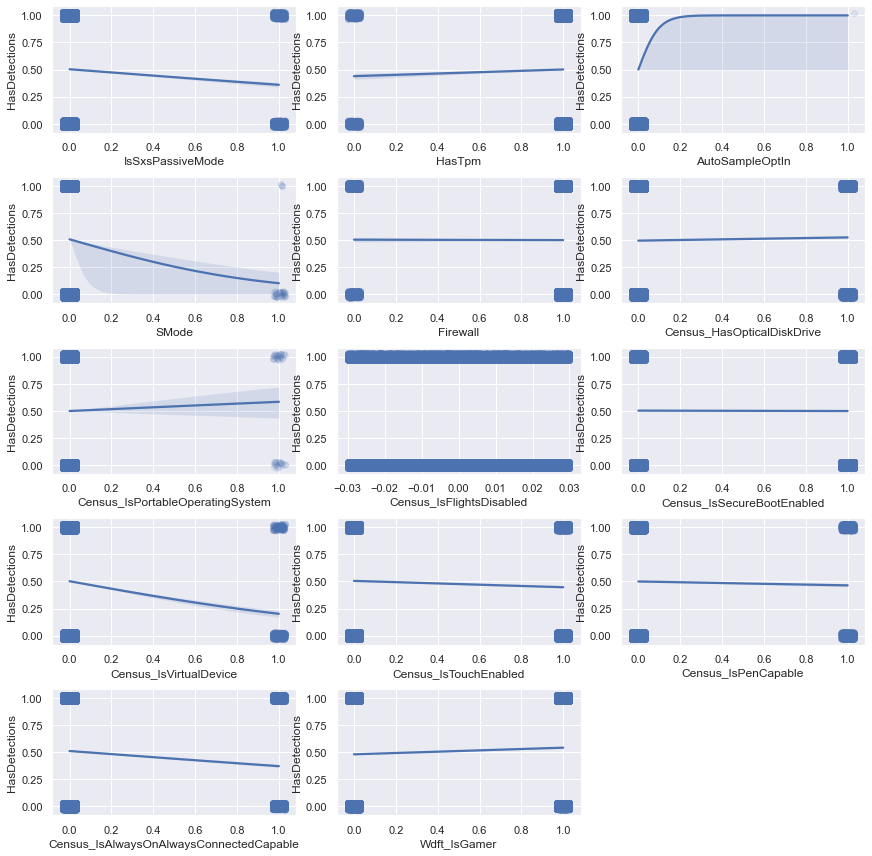

In [25]:
random.seed = 42

sns.set_style('darkgrid')
fig, axes = plt.subplots(5, 3, figsize=(12, 12))

for col, ax in zip(binary_col, axes.flatten()):
    sns.regplot(data=binary_df.sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                x_jitter=.03,
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)

plt.tight_layout()

### Chi2 test and Mutual Information between  binary features and target variable

In [26]:
X = df_dropna[binary_col].drop('HasDetections', axis=1)
y = df_dropna['HasDetections']

In [27]:
chi2_stat, p_val = chi2(X, y)
chi2_test_bin = pd.DataFrame({'Chi2-statistics':chi2_stat, 'p-value':p_val}, index=binary_col[:-1])    
chi2_test_bin.sort_values('Chi2-statistics', ascending=False).dropna()

,Chi2-statistics,p-value
Census_IsAlwaysOnAlwaysConnectedCapable,16169.159290,0.000000e+00
Wdft_IsGamer,6677.597784,0.000000e+00
Census_IsTouchEnabled,5588.241859,0.000000e+00
IsSxsPassiveMode,5344.091663,0.000000e+00
Census_HasOpticalDiskDrive,1814.602508,0.000000e+00
Census_IsVirtualDevice,1324.022389,6.805440e-290
Census_IsPenCapable,616.654420,3.994035e-136
Census_IsSecureBootEnabled,145.692078,1.515856e-33
Census_IsPortableOperatingSystem,89.208065,3.553972e-21
SMode,70.126725,5.561437e-17


In [28]:
mi = mutual_info_classif(X, y, random_state=42)
mi_bin = pd.DataFrame({'MI':mi}, index=binary_col[:-1])    
mi_bin.sort_values('MI', ascending=False)

,MI
HasTpm,0.282429
Firewall,0.276520
Census_IsSecureBootEnabled,0.108310
Wdft_IsGamer,0.028112
Census_IsTouchEnabled,0.009239
Census_IsAlwaysOnAlwaysConnectedCapable,0.004517
Census_HasOpticalDiskDrive,0.004035
IsSxsPassiveMode,0.000735
Census_IsVirtualDevice,0.000514
Census_IsPenCapable,0.000465


## Categorical Features

cardinality = df[cat_col].nunique().sort_values(ascending=False)
high_cardinality = cardinality[cardinality > 10].index
low_cardinality = cardinality[cardinality <= 10].index

for col in high_cardinality:
    print(f'Feature: {col} \nUnique Values Count: {df[col].nunique()}\n')   

Many of these categorical features are Identifiers and show very high cardinality. Let's look at these in detail.  

In [29]:
id_col = [col for col in df.columns if 'Identifier' in col]
id_col

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

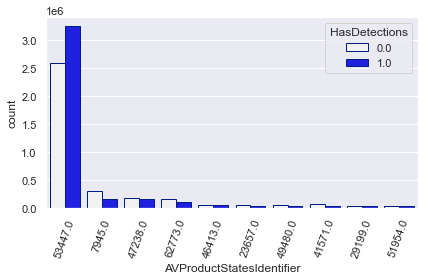

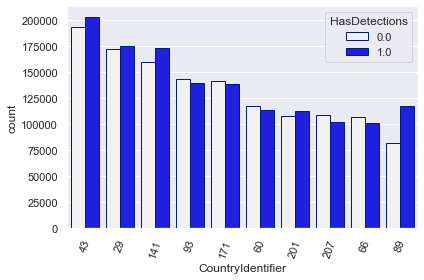

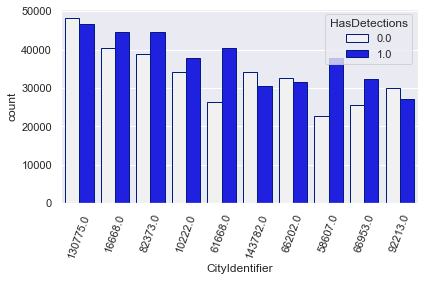

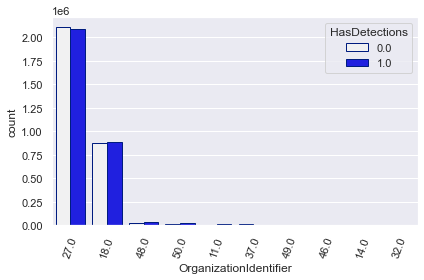

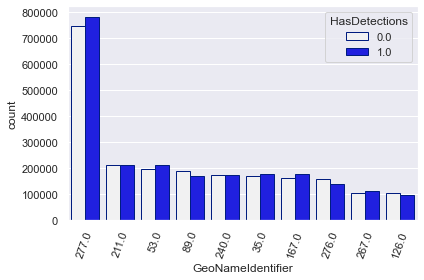

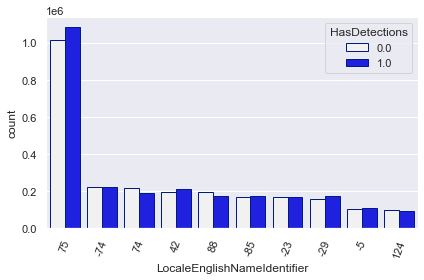

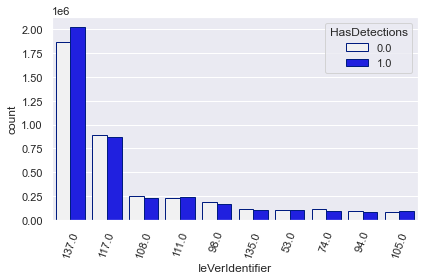

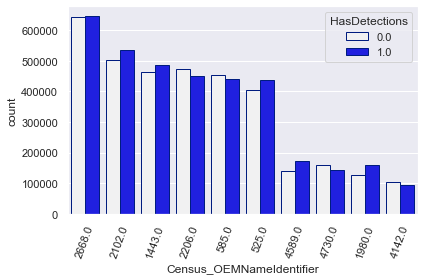

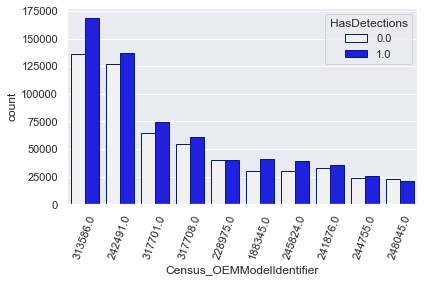

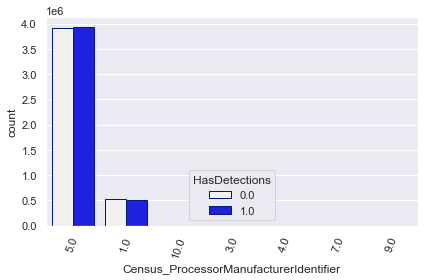

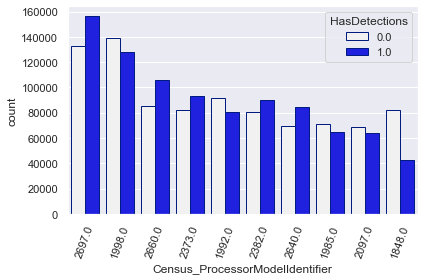

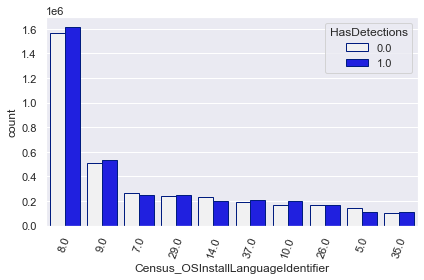

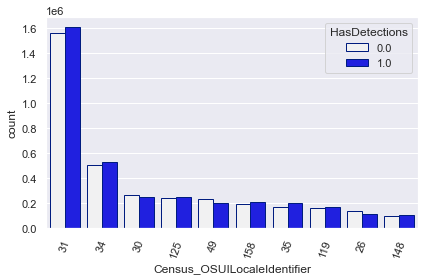

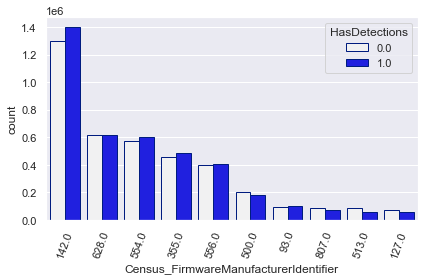

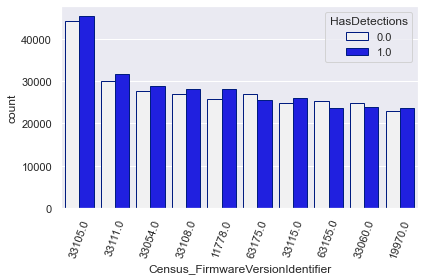

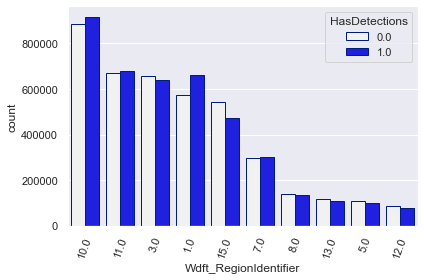

In [30]:
for col in id_col:
    plt.figure()
    sns.countplot(x=col,
                  hue='HasDetections',
                  data=df,
                  order=df[col].value_counts().index[:10],
                  color='blue',
                  edgecolor=sns.color_palette('dark', 1))
    #plt.legend(loc=1, title='HasDetections')
    plt.xticks(rotation = 70)
    plt.tight_layout();

These columns are numerically encoded. We can keep them like this or try different encodings, e.g. mean encoding (target encoding). Let's look at the remaining categorical features:

### Chi2 test and Mutual Information between ID categotical features and target variable

In [31]:
X = df_dropna[id_col]
y = df_dropna['HasDetections']

In [32]:
# encode feature containing negative labels 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X['LocaleEnglishNameIdentifier'] = le.fit_transform(X['LocaleEnglishNameIdentifier'])

<ipython-input-32-394c5fe09a69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['LocaleEnglishNameIdentifier'] = le.fit_transform(X['LocaleEnglishNameIdentifier'])


In [33]:
chi2_stat, p_val = chi2(X, y)
chi2_test_id = pd.DataFrame({'Chi2-statistics':chi2_stat, 'p-value':p_val}, index=id_col)    
chi2_test_id.sort_values('Chi2-statistics', ascending=False).dropna()

,Chi2-statistics,p-value
AVProductStatesIdentifier,2.519716e+08,0.000000e+00
Census_OEMModelIdentifier,1.320250e+06,0.000000e+00
Census_OEMNameIdentifier,7.053489e+05,0.000000e+00
Census_ProcessorModelIdentifier,6.755124e+05,0.000000e+00
Census_FirmwareManufacturerIdentifier,1.294096e+05,0.000000e+00
CityIdentifier,6.630780e+04,0.000000e+00
IeVerIdentifier,3.328540e+04,0.000000e+00
LocaleEnglishNameIdentifier,2.973272e+04,0.000000e+00
CountryIdentifier,7.732981e+03,0.000000e+00
Wdft_RegionIdentifier,1.570981e+03,0.000000e+00


In [34]:
mi = mutual_info_classif(X, y, random_state=42)
mi_id = pd.DataFrame({'MI':mi}, index=id_col)    
mi_id.sort_values('MI', ascending=False).dropna()

,MI
Census_ProcessorManufacturerIdentifier,0.276056
OrganizationIdentifier,0.187574
AVProductStatesIdentifier,0.168230
IeVerIdentifier,0.101959
Census_FirmwareManufacturerIdentifier,0.057334
Wdft_RegionIdentifier,0.056749
Census_OSInstallLanguageIdentifier,0.044523
Census_OEMNameIdentifier,0.039053
Census_OSUILocaleIdentifier,0.033788
GeoNameIdentifier,0.030997


<ipython-input-35-a5059b292a52>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


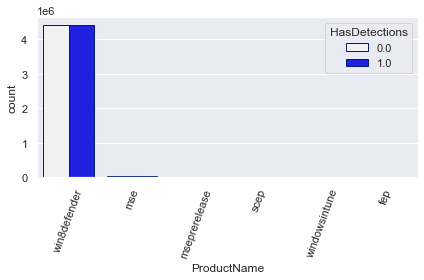

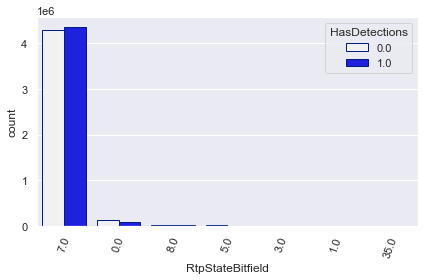

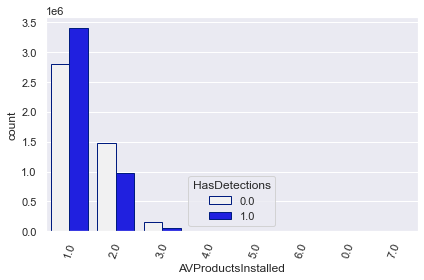

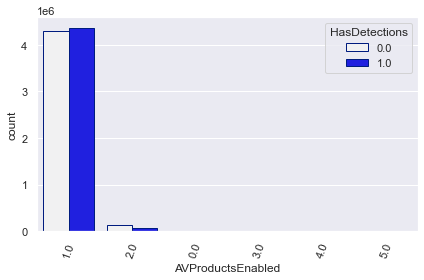

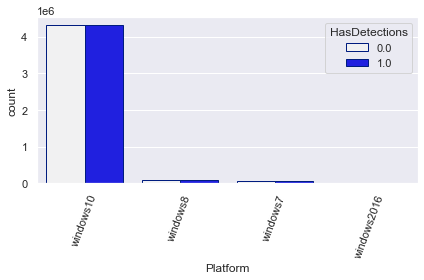

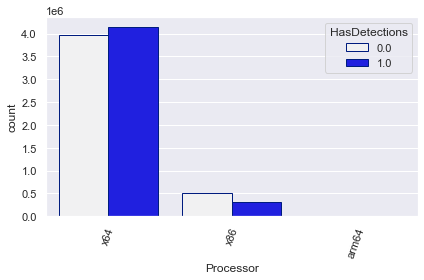

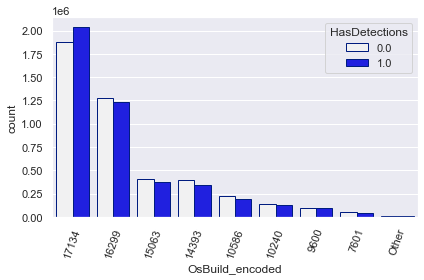

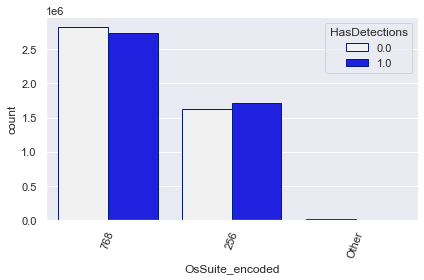

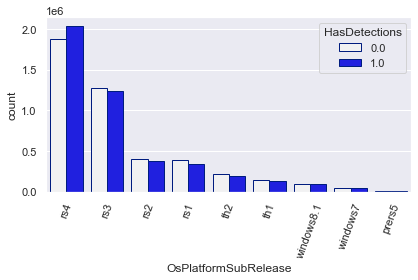

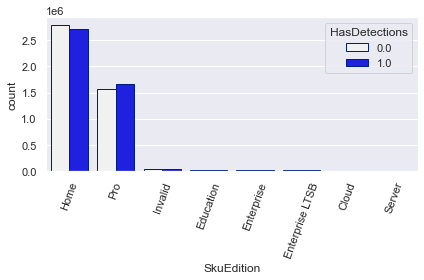

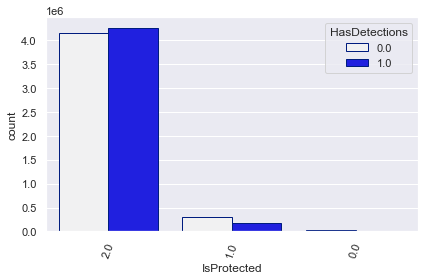

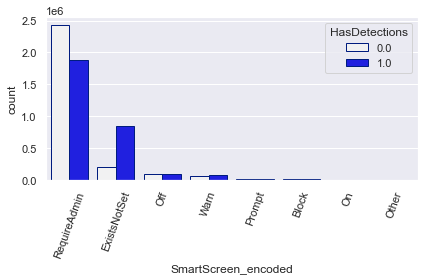

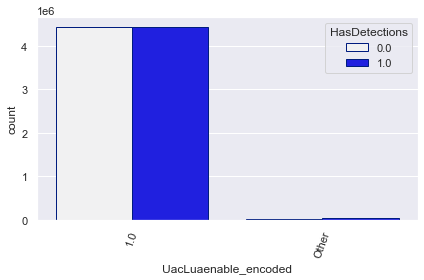

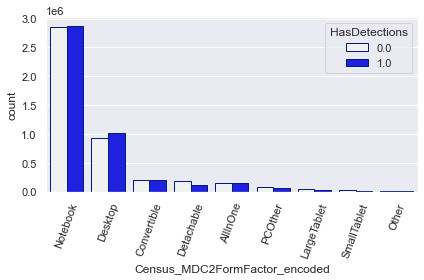

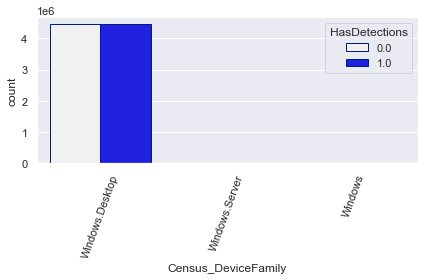

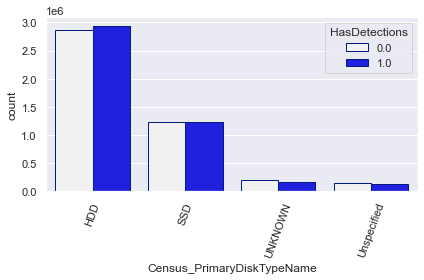

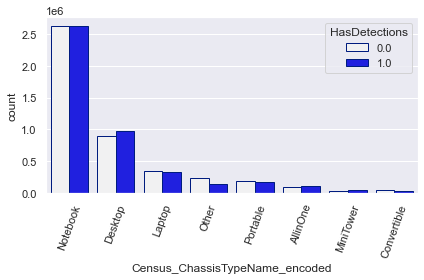

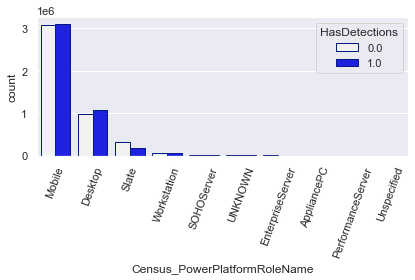

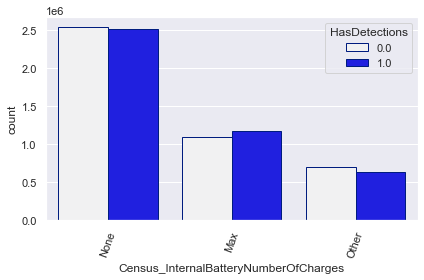

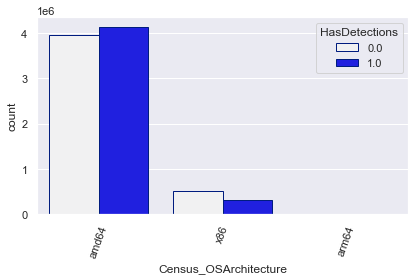

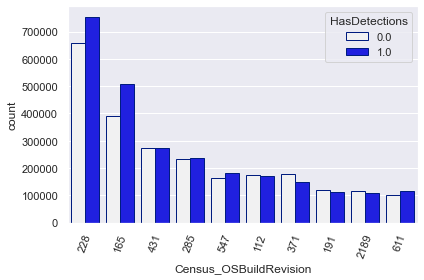

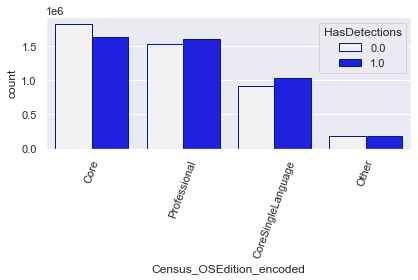

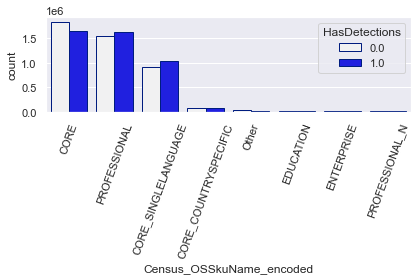

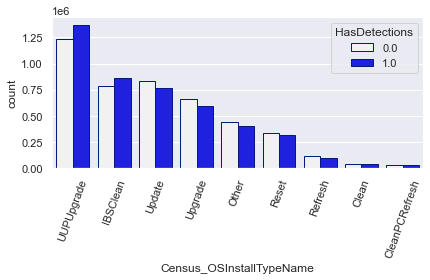

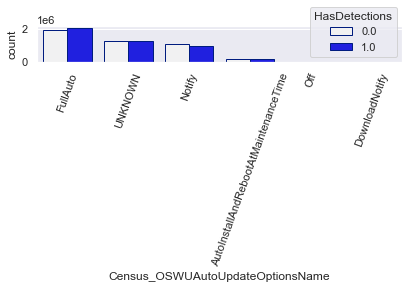

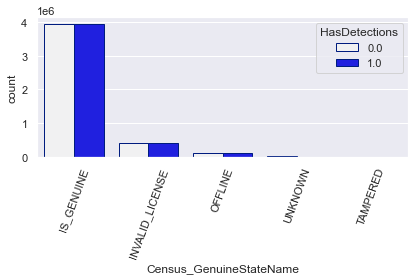

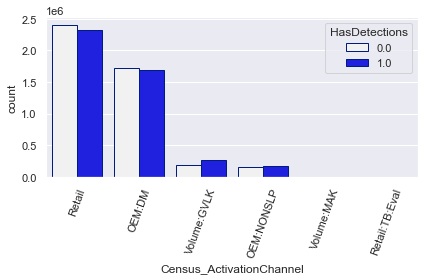

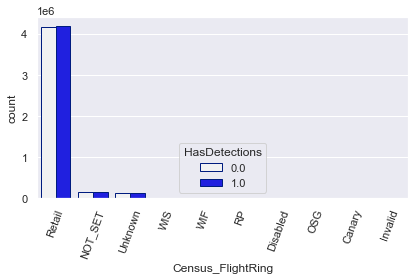

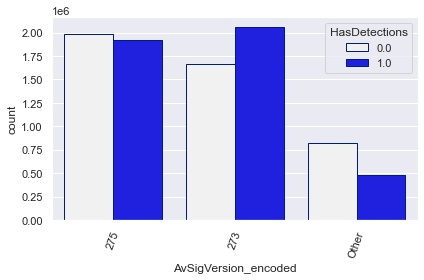

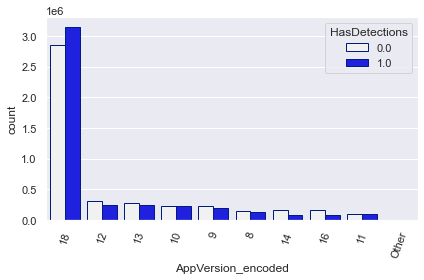

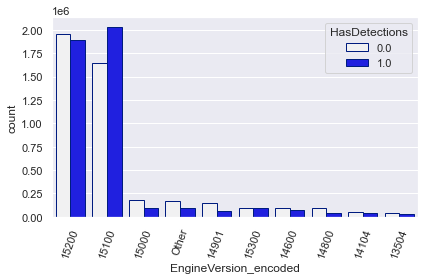

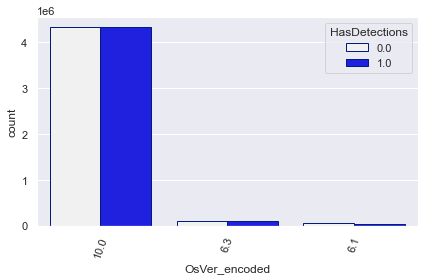

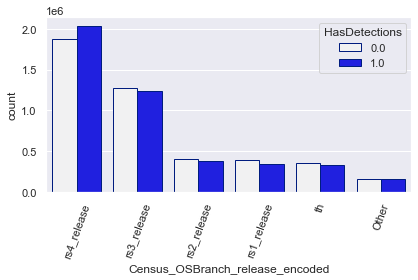

In [35]:
cat_col = [col for col in df.select_dtypes('category').columns.tolist() 
           if col not in id_col]

for col in cat_col:
    plt.figure()
    sns.countplot(x=col,
                  hue='HasDetections',
                  data=df,
                  order=df[col].value_counts().index[:10],
                  color='blue',
                  edgecolor=sns.color_palette('dark', 1))
    #plt.legend(loc=1, title='HasDetections')
    plt.xticks(rotation = 70)
    plt.tight_layout();

### Chi2 test and Mutual Information between onehot encoded categotical features and target variable

In [48]:
from sklearn.preprocessing import OneHotEncoder

X = df_dropna[cat_col]
ohe = OneHotEncoder()
ohe.fit(X)
onehot_X = ohe.transform(X)
y = df_dropna['HasDetections']

In [54]:
feat_names = ohe.get_feature_names(cat_col)
feat_names

array(['ProductName_mse', 'ProductName_win8defender',
       'RtpStateBitfield_0.0', 'RtpStateBitfield_1.0',
       'RtpStateBitfield_3.0', 'RtpStateBitfield_35.0',
       'RtpStateBitfield_5.0', 'RtpStateBitfield_7.0',
       'RtpStateBitfield_8.0', 'AVProductsInstalled_1.0',
       'AVProductsInstalled_2.0', 'AVProductsInstalled_3.0',
       'AVProductsInstalled_4.0', 'AVProductsInstalled_5.0',
       'AVProductsInstalled_6.0', 'AVProductsEnabled_0.0',
       'AVProductsEnabled_1.0', 'AVProductsEnabled_2.0',
       'AVProductsEnabled_3.0', 'AVProductsEnabled_4.0',
       'AVProductsEnabled_5.0', 'Platform_windows10', 'Platform_windows7',
       'Platform_windows8', 'Processor_arm64', 'Processor_x64',
       'Processor_x86', 'OsBuild_encoded_10240', 'OsBuild_encoded_10586',
       'OsBuild_encoded_14393', 'OsBuild_encoded_15063',
       'OsBuild_encoded_16299', 'OsBuild_encoded_17134',
       'OsBuild_encoded_7601', 'OsBuild_encoded_9600',
       'OsBuild_encoded_Other', 'OsSuite_enco

In [55]:
chi2_stat, p_val = chi2(onehot_X, y)
chi2_test_cat = pd.DataFrame({'Chi2-statistics':chi2_stat, 'p-value':p_val}, index=feat_names)    
chi2_test_cat.sort_values('Chi2-statistics', ascending=False).dropna()

,Chi2-statistics,p-value
SmartScreen_encoded_ExistsNotSet,2.214759e+05,0.000000e+00
SmartScreen_encoded_RequireAdmin,5.698300e+04,0.000000e+00
AvSigVersion_encoded_Other,4.569324e+04,0.000000e+00
AVProductsInstalled_2.0,4.478073e+04,0.000000e+00
AVProductsInstalled_1.0,2.998999e+04,0.000000e+00
Processor_x86,2.574212e+04,0.000000e+00
Census_OSArchitecture_x86,2.557563e+04,0.000000e+00
AvSigVersion_encoded_273,2.183277e+04,0.000000e+00
EngineVersion_encoded_15100,2.160499e+04,0.000000e+00
EngineVersion_encoded_14901,1.711393e+04,0.000000e+00


In [56]:
mi = mutual_info_classif(onehot_X, y, random_state=42)
mi_cat = pd.DataFrame({'MI':mi}, index=feat_names)    
mi_cat.sort_values('MI', ascending=False).dropna()

,MI
SmartScreen_encoded_ExistsNotSet,4.472139e-02
SmartScreen_encoded_RequireAdmin,3.656643e-02
AVProductsInstalled_1.0,1.334974e-02
AVProductsInstalled_2.0,1.008430e-02
AvSigVersion_encoded_Other,7.977737e-03
AvSigVersion_encoded_273,6.238907e-03
EngineVersion_encoded_15100,6.143606e-03
AppVersion_encoded_18,5.443168e-03
Processor_x64,4.417952e-03
Processor_x86,4.417513e-03


### Chi2 and MI Full Dataset

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [87]:
# Separate features by data type: categorical, ID, numerical and binary
id_col = ['AVProductStatesIdentifier',
          'CountryIdentifier',
          'CityIdentifier',
          'OrganizationIdentifier',
          'GeoNameIdentifier',
          'LocaleEnglishNameIdentifier',
          'IeVerIdentifier',
          'Census_OEMNameIdentifier',
          'Census_OEMModelIdentifier',
          'Census_ProcessorManufacturerIdentifier',
          'Census_ProcessorModelIdentifier',
          'Census_OSInstallLanguageIdentifier',
          'Census_OSUILocaleIdentifier',
          'Census_FirmwareManufacturerIdentifier',
          'Census_FirmwareVersionIdentifier',
          'Wdft_RegionIdentifier']
cat_col = [col for col in df.select_dtypes('category').columns.tolist() 
           if col not in id_col]
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in id_col
           if col not in binary_col
           if col != 'HasDetections']

len(cat_col), len(id_col), len(binary_col), len(num_col) 

(33, 16, 14, 7)

In [90]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for binary data
binary_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data encoded as numerical ID's
id_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('bin', binary_transformer, binary_col),
        ('id', id_transformer, id_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [92]:
X = df.loc[:, df.columns != 'HasDetections']
le = preprocessing.LabelEncoder()
X['LocaleEnglishNameIdentifier'] = le.fit_transform(X['LocaleEnglishNameIdentifier'])
y = df['HasDetections']
df_transformed = preprocessor.fit_transform(X)
df_transformed

<ipython-input-92-af4502c3b5b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['LocaleEnglishNameIdentifier'] = le.fit_transform(X['LocaleEnglishNameIdentifier'])


<8921478x518 sparse matrix of type '<class 'numpy.float64'>'
	with 526812071 stored elements in Compressed Sparse Row format>

In [94]:
onehot_col = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_names = num_col + binary_col + id_col + onehot_col.tolist()

In [95]:
chi2_stat, p_val = chi2(df_transformed, y)
chi2_test_all = pd.DataFrame({'Chi2-statistics':chi2_stat, 'p-value':p_val}, index=columns_names)    
chi2_test_all.sort_values('Chi2-statistics', ascending=False).dropna()

,Chi2-statistics,p-value
Census_PrimaryDiskTotalCapacity,5.635045e+09,0.000000e+00
Census_SystemVolumeTotalCapacity,5.138028e+08,0.000000e+00
AVProductStatesIdentifier,4.983751e+08,0.000000e+00
Census_TotalPhysicalRAM,1.235526e+08,0.000000e+00
Census_OEMModelIdentifier,4.953983e+06,0.000000e+00
CityIdentifier,2.080818e+06,0.000000e+00
Census_OEMNameIdentifier,1.678689e+06,0.000000e+00
Census_ProcessorModelIdentifier,1.377713e+06,0.000000e+00
Census_InternalPrimaryDisplayResolutionHorizontal,7.849425e+05,0.000000e+00
Census_FirmwareManufacturerIdentifier,5.122008e+05,0.000000e+00


mi = mutual_info_classif(df_transformed, y, random_state=42)
mi_all = pd.DataFrame({'MI':mi}, index=columns_names)    
mi_all.sort_values('MI', ascending=False).dropna()

## Summary